In [1]:
import sys
import os
from os.path import join
import cv2
import torch
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
from tqdm.auto import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("/n/home13/xupan/sompolinsky_lab/DiffusionObjectRelation/utils")
from cv2_eval_utils import find_classify_object_masks
import pickle
positive_threshold = 180 

/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#saveroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/latent_store"
figdir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/feature_classifier'
syndir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/feature_classifier/synopsis"
os.makedirs(syndir, exist_ok=True)

### Collect all layers features

In [37]:
syn_col = []
feature_names = [
    "leftobj_vs_rightobj",
    "rightobj_vs_leftobj",
    # "obj_vs_others",
    # "triangle_vs_others", 
    # "circle_vs_others",
    # "square_vs_others", 
    # "blue_obj_vs_others",
    # "red_obj_vs_others",
    # "red_circle_vs_others",
    # "red_square_vs_others",
    # "red_triangle_vs_others", 
    # "blue_circle_vs_others", 
    # "blue_square_vs_others",
    # "blue_triangle_vs_others",
    # "topobj_vs_others", 
    # "bottomobj_vs_others",
    # "topobj_vs_bottomobj"
]
# annot_label = "triangle_vs_others"
for layer_index in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    for annot_label in feature_names:
        for t_index in reversed(range(14)):
            for training_pass in [("cond",), ("uncond",), ("cond", "uncond")]:
                training_pass_str = "-".join(training_pass)+"Pass"
                if not os.path.exists(join(figdir, f"red_blue_8_relation_diff_layer{layer_index}_t{t_index}_{annot_label}_classifier_{training_pass_str}.pkl")):
                    print(f"No classifier found for at layer {layer_index} t_index {t_index} {annot_label} and training pass {training_pass_str}")
                    continue
                data = pkl.load(open(join(figdir, f"red_blue_8_relation_diff_layer{layer_index}_t{t_index}_{annot_label}_classifier_{training_pass_str}.pkl"), 'rb'))
                clf, boundary_vector, eval_dict = data["classifier"], data["boundary_vector"], data["eval_dict"]
                stats_dict = eval_dict.copy()
                stats_dict["layer_index"] = layer_index
                stats_dict["t_index"] = t_index
                stats_dict["training_pass"] = training_pass_str
                stats_dict["annot_label"] = annot_label
                stats_dict["boundary_vector"] = boundary_vector
                # stats_dict.pop('classifier')
                # stats_dict.pop('boundary_vector')
                syn_col.append(stats_dict)
            # print(f"t_index: {t_index}, training_pass: {training_pass_str}, eval_dict: {eval_dict}")
            # print(f"boundary_vector: {boundary_vector}")
syn_df = pd.DataFrame(syn_col)
# syn_df.to_csv(join(figdir, f"red_blue_8_relation_diff_stats_synopsis.csv"), index=False)
syn_df.to_pickle(join(syndir, f"red_blue_left_right_relation_feature_classifier_alllayers_stats_synopsis.pkl"))


No classifier found for at layer 8 t_index 0 leftobj_vs_rightobj and training pass condPass
No classifier found for at layer 8 t_index 0 leftobj_vs_rightobj and training pass uncondPass
No classifier found for at layer 8 t_index 0 leftobj_vs_rightobj and training pass cond-uncondPass
No classifier found for at layer 8 t_index 1 rightobj_vs_leftobj and training pass uncondPass
No classifier found for at layer 8 t_index 1 rightobj_vs_leftobj and training pass cond-uncondPass
No classifier found for at layer 8 t_index 0 rightobj_vs_leftobj and training pass condPass
No classifier found for at layer 8 t_index 0 rightobj_vs_leftobj and training pass uncondPass
No classifier found for at layer 8 t_index 0 rightobj_vs_leftobj and training pass cond-uncondPass
No classifier found for at layer 10 t_index 0 leftobj_vs_rightobj and training pass condPass
No classifier found for at layer 10 t_index 0 leftobj_vs_rightobj and training pass uncondPass
No classifier found for at layer 10 t_index 0 lef

### Accuracy as function of layer

In [3]:
syn_df = pd.read_pickle(join(syndir, f"red_blue_left_right_relation_feature_classifier_alllayers_stats_synopsis.pkl"))

In [5]:
syn_df.annot_label.unique()

array(['leftobj_vs_rightobj', 'rightobj_vs_leftobj'], dtype=object)

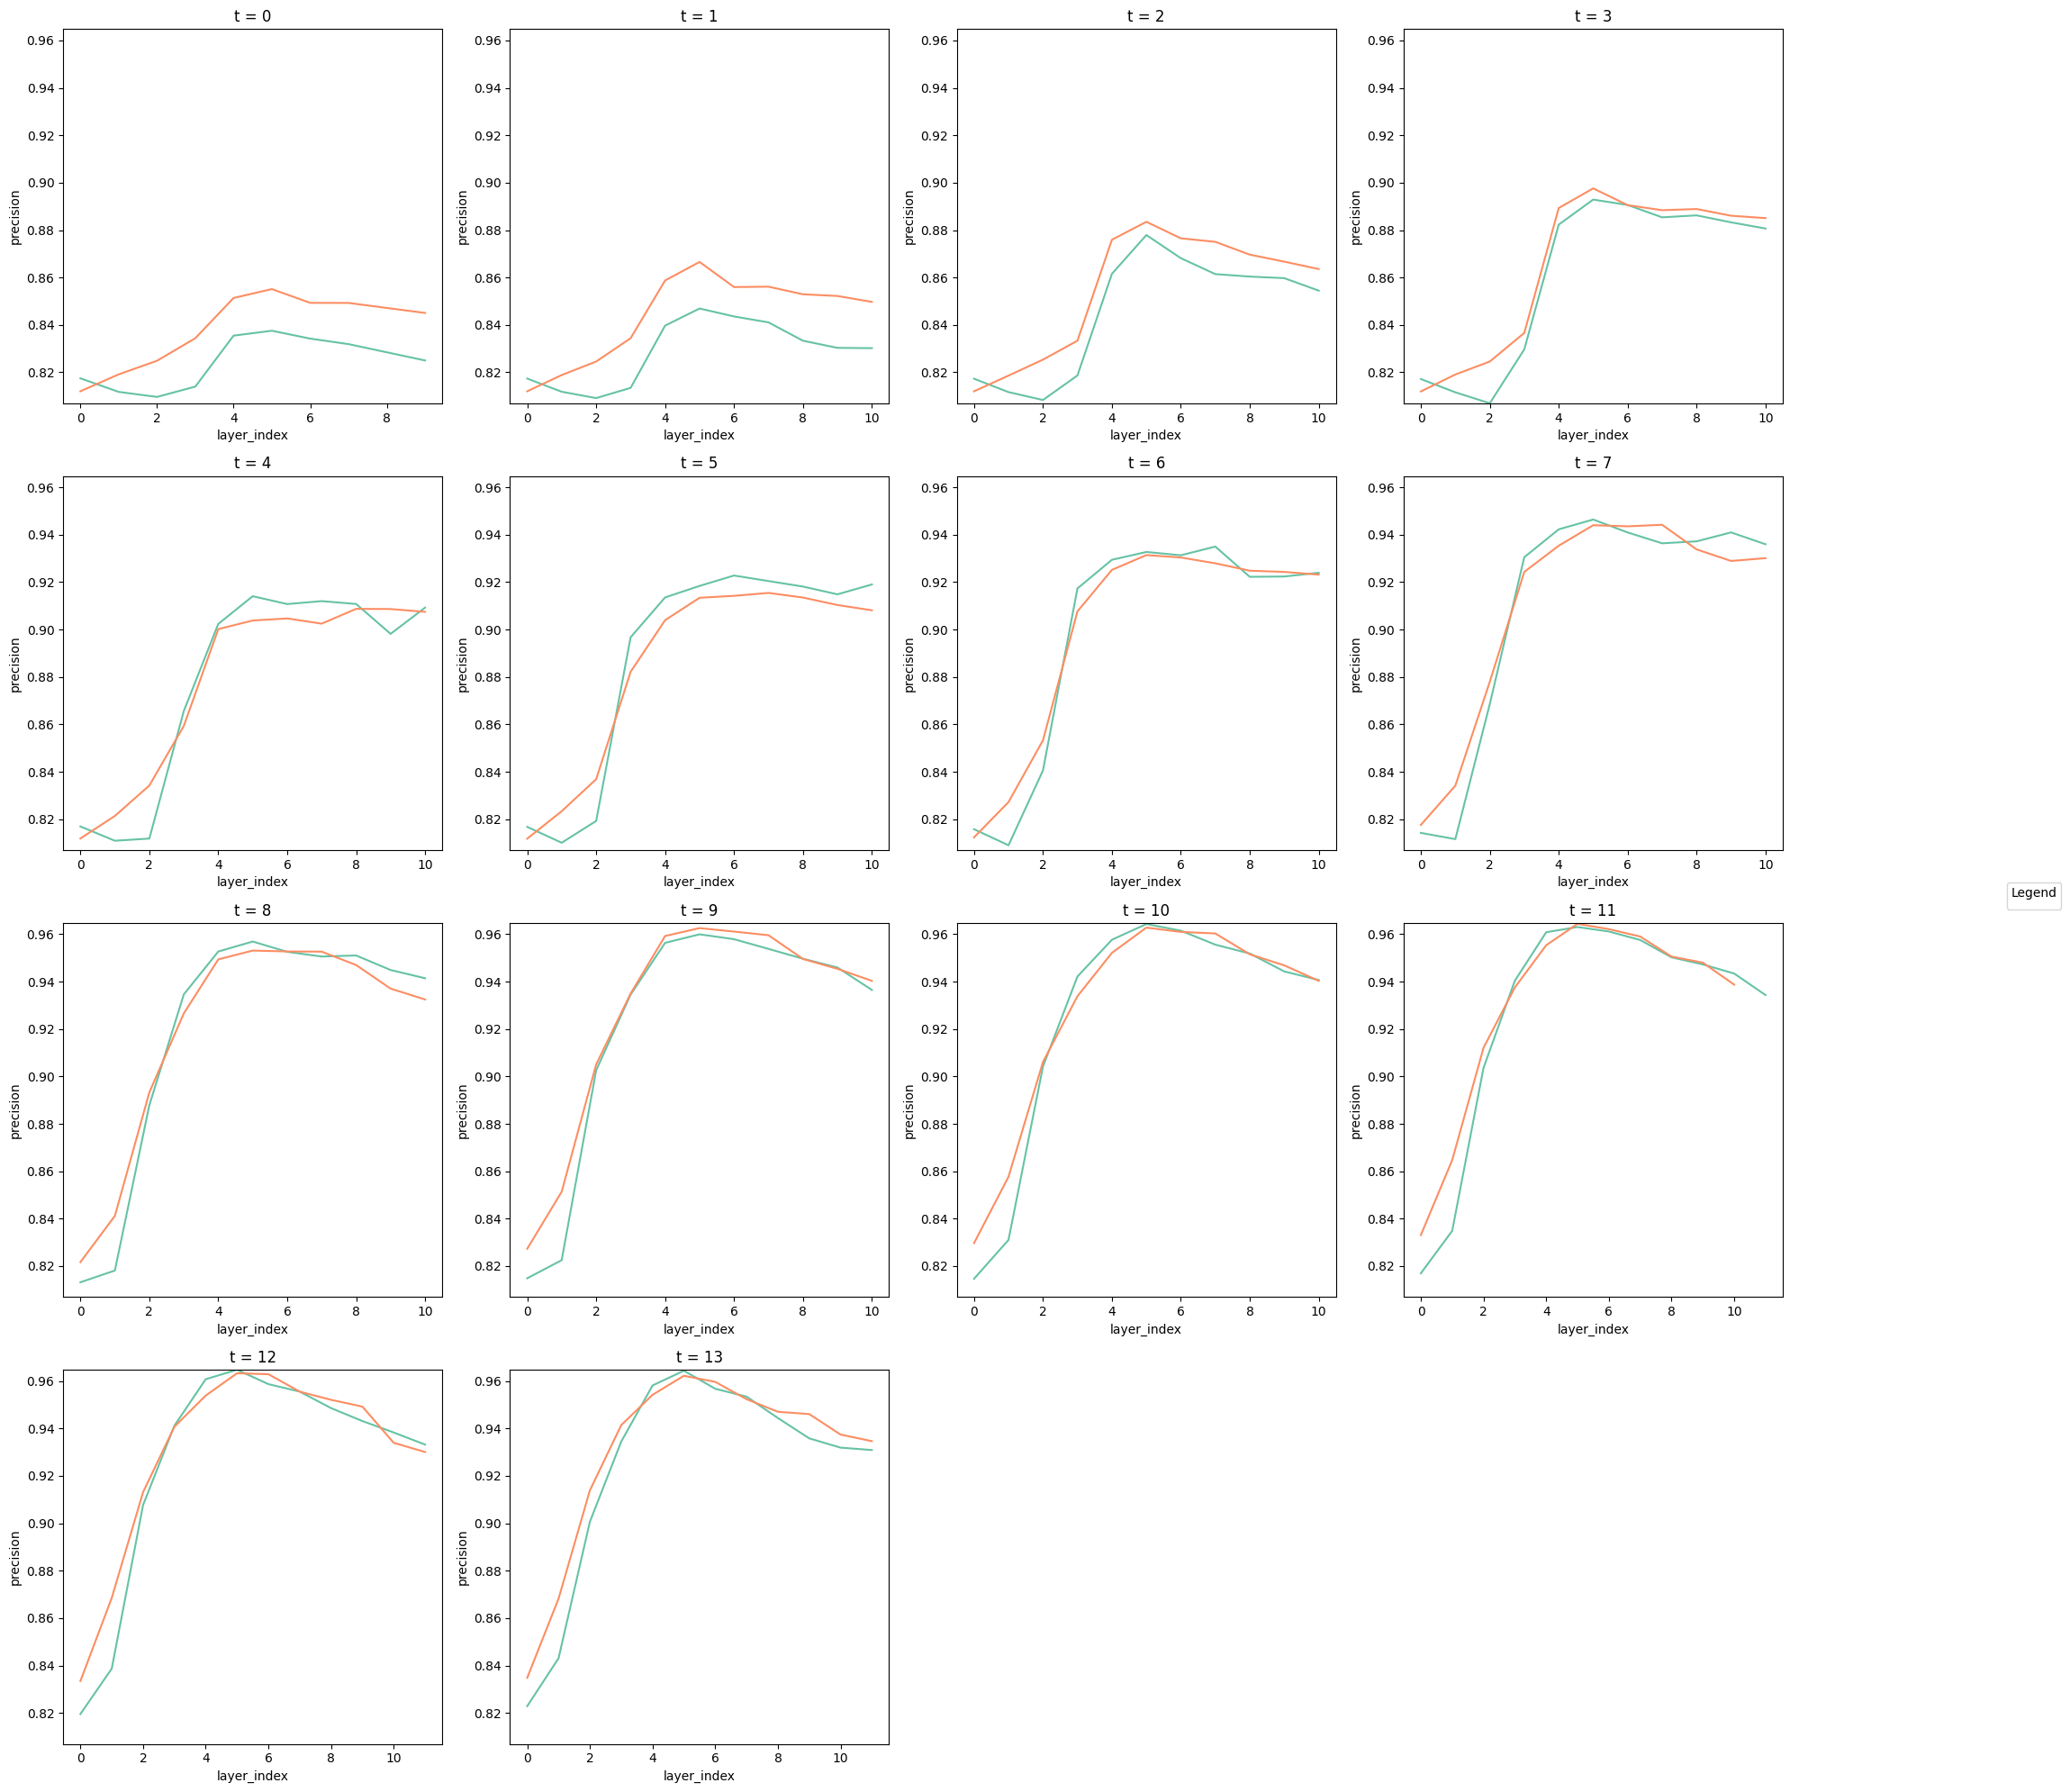

In [40]:
# Create a grid of subplots - 4 rows x 4 cols will fit 14 plots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

# Get global min and max precision values
all_data = syn_df.query("training_pass == 'condPass'")
y_min = all_data['precision'].min()
y_max = all_data['precision'].max()

# Plot for each t_index
for t in range(14):
    ax = axes[t]
    # Plot without legend for all subplots
    sns.lineplot(data=syn_df.query("t_index == @t and training_pass == 'condPass'"), 
                 x="layer_index", y="precision",
                 style="training_pass", hue="annot_label", 
                 palette="Set2", ax=ax,
                 legend=False)
    ax.set_title(f't = {t}')
    # Set same y-axis limits for all subplots
    ax.set_ylim(y_min, y_max)

# Create a separate legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5),
          fontsize='small', title='Legend')

# Remove empty subplots
for i in range(14, 16):
    fig.delaxes(axes[i])

plt.tight_layout()


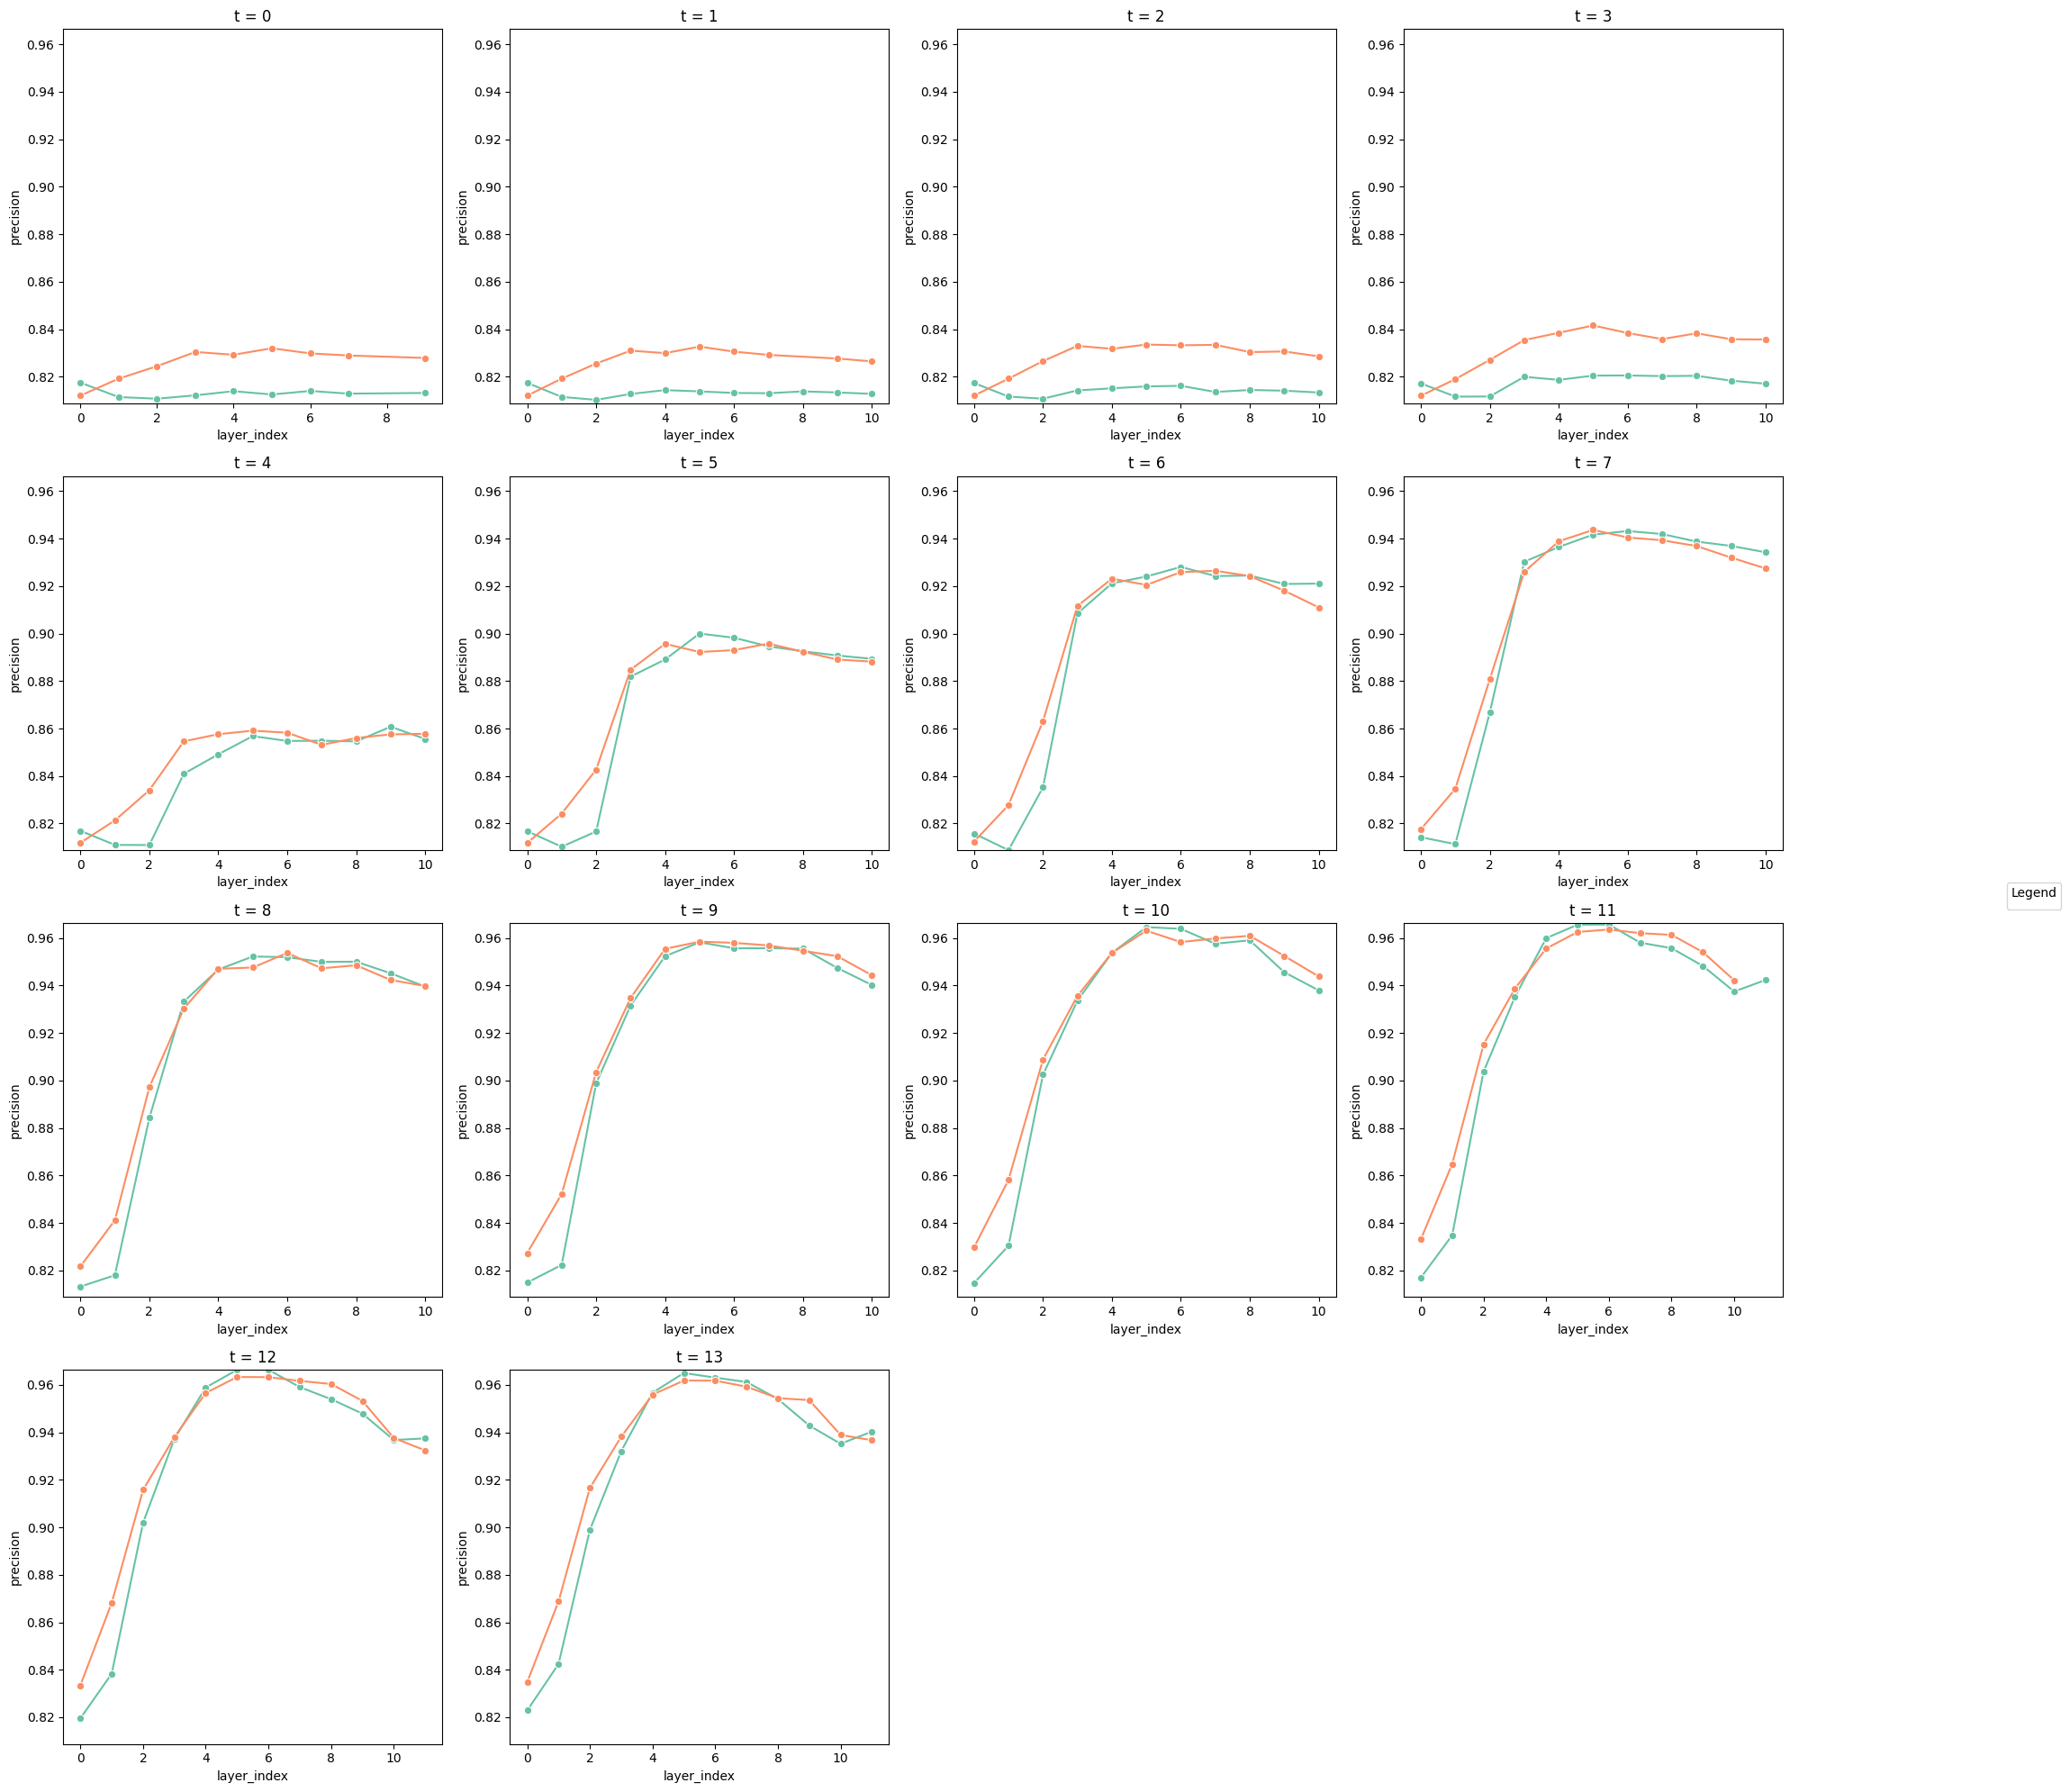

In [41]:
# Create a grid of subplots - 4 rows x 4 cols will fit 14 plots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

# Get global min and max precision values
all_data = syn_df.query("training_pass == 'uncondPass'")
y_min = all_data['precision'].min()
y_max = all_data['precision'].max()

# Plot for each t_index
for t in range(14):
    ax = axes[t]
    # Plot without legend for all subplots
    sns.lineplot(data=syn_df.query("t_index == @t and training_pass == 'uncondPass'"), 
                 x="layer_index", y="precision",
                 style="training_pass", hue="annot_label", 
                 palette="Set2", markers=True, ax=ax,
                 legend=False)
    ax.set_title(f't = {t}')
    # Set same y-axis limits for all subplots
    ax.set_ylim(y_min, y_max)

# Create a separate legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5),
          fontsize='small', title='Legend')

# Remove empty subplots
for i in range(14, 16):
    fig.delaxes(axes[i])

plt.tight_layout()


In [26]:
# Print recall values for all layers and time points
for t in range(14):
    print(f"\nTime step {t}:")
    for layer in range(12):
        print(f"\nLayer {layer}:")
        print(syn_df.query("t_index == @t and training_pass == 'uncondPass' and layer_index == @layer").\
              set_index("annot_label")["recall"].sort_values())


Time step 0:

Layer 0:
annot_label
leftobj_vs_rightobj    0.804372
rightobj_vs_leftobj    0.825282
Name: recall, dtype: float64

Layer 1:
Series([], Name: recall, dtype: float64)

Layer 2:
annot_label
rightobj_vs_leftobj    0.810025
leftobj_vs_rightobj    0.822222
Name: recall, dtype: float64

Layer 3:
Series([], Name: recall, dtype: float64)

Layer 4:
annot_label
rightobj_vs_leftobj    0.804214
leftobj_vs_rightobj    0.829872
Name: recall, dtype: float64

Layer 5:
annot_label
rightobj_vs_leftobj    0.807483
leftobj_vs_rightobj    0.830237
Name: recall, dtype: float64

Layer 6:
Series([], Name: recall, dtype: float64)

Layer 7:
annot_label
rightobj_vs_leftobj    0.806030
leftobj_vs_rightobj    0.825865
Name: recall, dtype: float64

Layer 8:
Series([], Name: recall, dtype: float64)

Layer 9:
annot_label
rightobj_vs_leftobj    0.807120
leftobj_vs_rightobj    0.825865
Name: recall, dtype: float64

Layer 10:
Series([], Name: recall, dtype: float64)

Layer 11:
Series([], Name: recall, dtyp

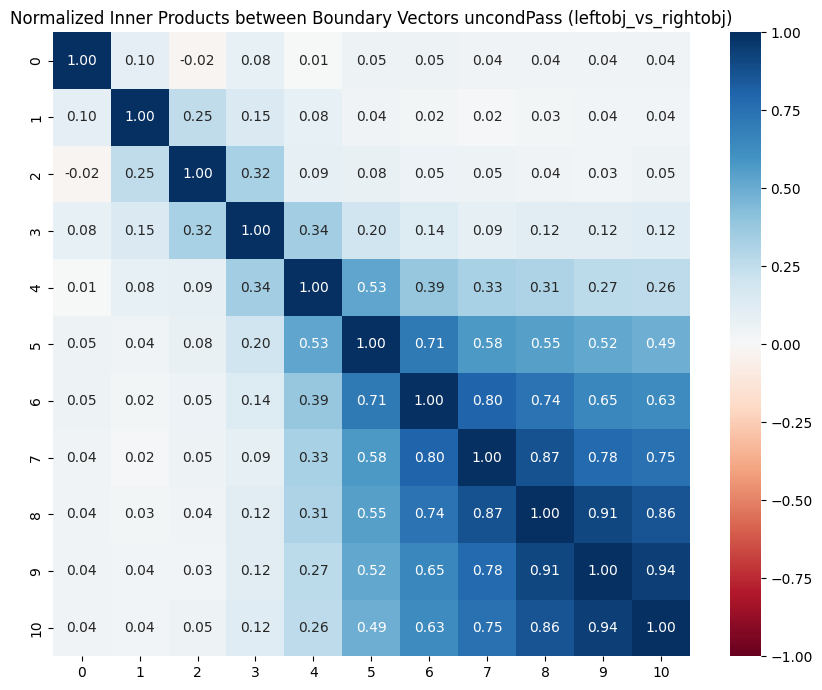

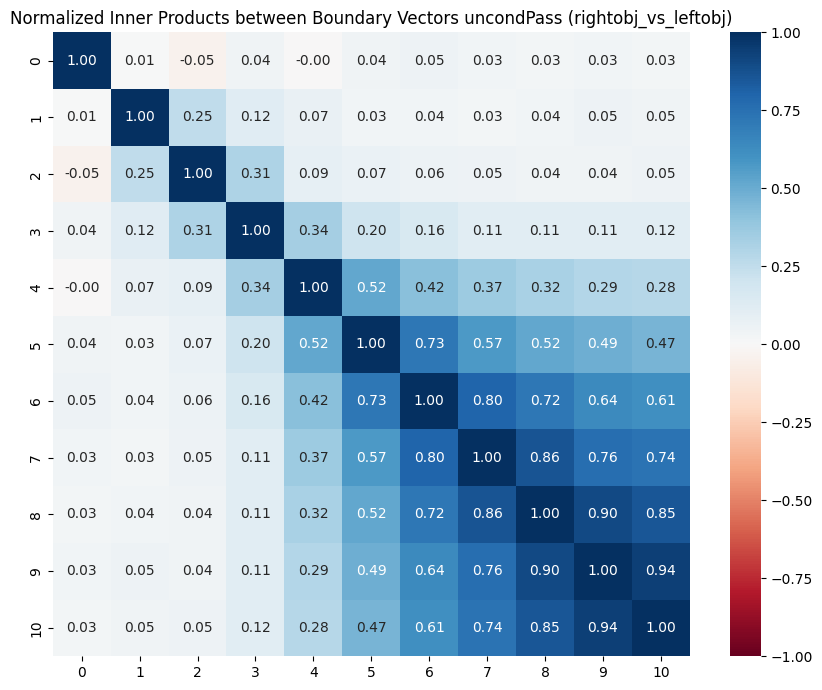

In [42]:
# Compute inner products between boundary vectors for each t_index
# Filter data for current t_index and cond-uncondPass
for annot_label in ["leftobj_vs_rightobj", "rightobj_vs_leftobj"]:
    df_subsel = syn_df.query("annot_label == @annot_label and training_pass == 'condPass' and t_index == 4")
    df_subsel = df_subsel.sort_values(by="layer_index")
    # Extract boundary vectors and labels
    vectors = np.stack(df_subsel['boundary_vector'].values)
    labels = df_subsel['layer_index'].values

    # Compute normalized inner products
    norm_vectors = vectors / np.linalg.norm(vectors, axis=1)[:, None]
    inner_products = norm_vectors @ norm_vectors.T

    # Create heatmap
    plt.figure(figsize=(8.5, 7))
    sns.heatmap(inner_products, 
                xticklabels=labels, 
                yticklabels=labels,
                annot=True, 
                fmt='.2f',
                cmap='RdBu',
                vmin=-1, 
                vmax=1,
                center=0)
    plt.title(f'Normalized Inner Products between Boundary Vectors uncondPass ({annot_label})')
    plt.tight_layout()
    plt.show()

### Plot norm vector

In [76]:
# Get boundary vector from syn_df for specific parameters
layer_idx = 10  # Layer index
t_idx = 5      # Time index
training = "condPass"  # Training pass
label = "rightobj_vs_leftobj"  # Annotation label

# Filter dataframe to get boundary vector
boundary_vector = syn_df.query("layer_index == @layer_idx and t_index == @t_idx and training_pass == @training and annot_label == @label")['boundary_vector']



red is to the left of blue


/tmp/ipykernel_1937511/370665634.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  feature_map = embedding @ feature_vector # (H*W,)


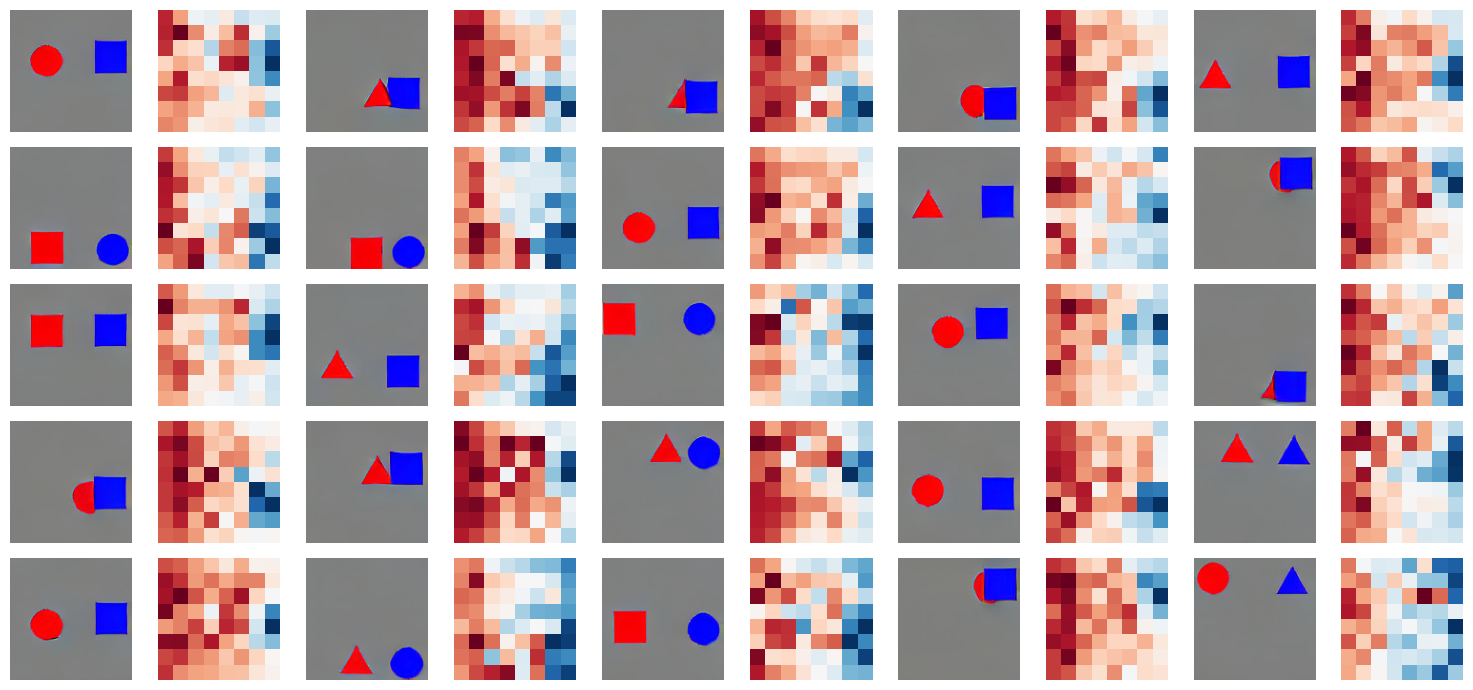

In [80]:
feature_vector = np.array(boundary_vector)[0]
saveroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/latent_store_norm1"
latent_file = "red_blue_8_pos_rndembposemb_img_latent_residual_allblocks_prompt2_seed8.pkl"
latent_path = os.path.join(saveroot, latent_file)

with open(latent_path, 'rb') as f:
    data = pickle.load(f)
t_index = 13
print(data['prompt'])
plt.figure(figsize=(15,7))
for i in range(25):
    # This subplot call is unnecessary since we're using 5x10 grid below
    # plt.subplot(5,5,i+1) 
    
    # Plot original image on left half
    plt.subplot(5,10,2*i+1)
    plt.imshow(data['image_logs'][0]['images'][i])
    plt.axis('off')
    
    # Plot feature activation map on right half
    plt.subplot(5,10,2*i+2)
    embedding = data['block_10_residual_spatial_state_traj'][t_index][i,...] # (H*W, C)
    feature_map = embedding @ feature_vector # (H*W,)
    feature_map = feature_map.reshape(8,8) # Reshape to spatial dimensions
    plt.imshow(feature_map, cmap='RdBu')
    plt.axis('off')
plt.tight_layout()
plt.show()

embedding_extracted = data['block_11_residual_spatial_state_traj'][t_index][:25,...]

### Normalize and scale and shift the feature vectors

In [22]:
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/utils")
from pixart_utils import state_dict_convert
from pixart_utils import construct_diffuser_transformer_from_config
from pixart_utils import construct_diffuser_transformer_from_config, construct_diffuser_pipeline_from_config

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [26]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
ckptdir = join(savedir, "checkpoints")
config = read_config(join(savedir, 'config.py'))
model = construct_diffuser_transformer_from_config(config)
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
model.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
model.eval()
model.to("cpu");

In [36]:
with torch.no_grad():
    t_blocks, t_embs = model.adaln_single(torch.arange(1000), 
                       added_cond_kwargs={'resolution': None, 'aspect_ratio':None})


In [44]:
layer_index = 1
with torch.no_grad():
    scale_shift_table = model.transformer_blocks[layer_index].scale_shift_table
    B = t_blocks.shape[0]
    shift_msa_src, scale_msa_src, gate_msa_src, \
    shift_mlp_src, scale_mlp_src, gate_mlp_src = \
    (scale_shift_table[None, :, :] + t_blocks.reshape(B, 6, -1)).chunk(6, dim=1)
print(scale_shift_table.shape)
print(shift_msa_src.shape)

torch.Size([6, 768])
torch.Size([1000, 1, 768])


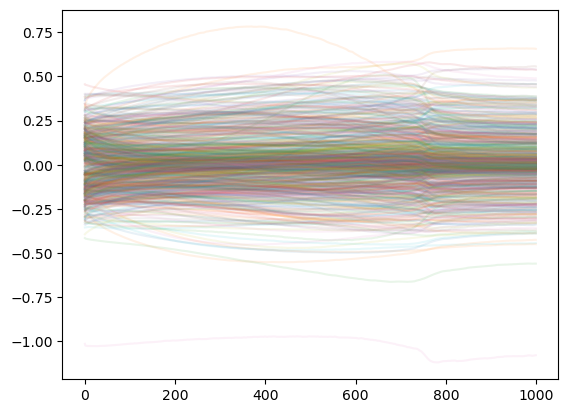

In [52]:
plt.plot(shift_msa_src[:, 0, :].\
    cpu().numpy(), alpha=0.1)
plt.show()

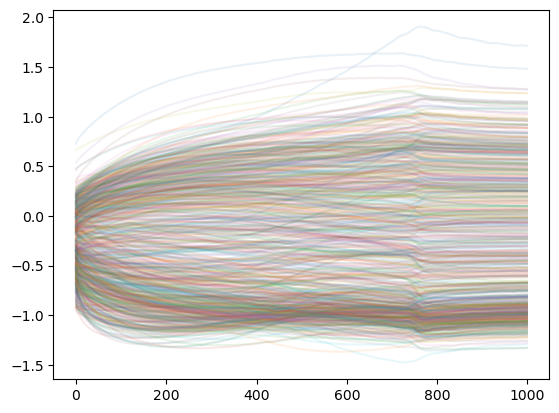

In [51]:
plt.plot(scale_msa_src[:, 0, :].cpu().numpy(), alpha=0.1)
plt.show()

In [47]:
print(t_blocks.shape)
print(t_embs.shape)

torch.Size([1000, 4608])
torch.Size([1000, 768])


In [63]:
import torch.nn as nn
norm_layer = nn.LayerNorm(768, eps=1e-5, elementwise_affine=False)

In [60]:
# Check the layernorm layer has no learnable parameters
model.transformer_blocks[layer_index].norm1.state_dict()

OrderedDict()

In [61]:
model.transformer_blocks[layer_index].norm1

LayerNorm((768,), eps=1e-06, elementwise_affine=False)